# Hypothesis Testing

There are two types of binary classification algorithms from which to choose (in the context of this project): *Linear Discriminant Analysis* (**LDA**) and *Quadratic Discriminant Analysis* (**QDA**) 

- **LDA** assumes the two classes have the same covariance matrix: $\boldsymbol{\Sigma}_{+} = \boldsymbol{\Sigma}_{-}$ 
- **QDA** assumes that the covariance matrices between the classes are *different*; i.e., that $\boldsymbol{\Sigma}_{+} \neq \boldsymbol{\Sigma}_{-}$ 

where '$+$' denotes one of the classes and '$-$' denotes the other.

*(for notes on LDA and QDA, see Lecture 18. For notes on this particular hypothesis test, see Lecture 11)*

## The Data: Pima Indians Diabetes Database

The data set can be obtained from the R package `mlbench`. More specifically, after installing the package, you can obtain the data sets by running

```r
library(mlbench)
data(PimaIndiansDiabetes)
```

For this data set, people are usually interested in predicting the onset of diabetes in female Pima Indians from medical record data.

See [the documentation](https://www.rdocumentation.org/packages/mlbench/versions/0.5-7/topics/PimaIndiansDiabetes).

In [1]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
import pandas as pd


def convert_r_to_pandas(
        lib: str, data: str, set_index: bool = False
    ) -> pd.DataFrame:
    """
    Convert R data to a pandas DataFrame.
    
    :param lib The library name.
    :param data The data name.
    :param set_index: Whether the dataset contains row labels that should be 
        set as the DataFrame index.
    :return: A pandas DataFrame containing the data.
    """

    pandas2ri.activate()

    robjects.r(f"library({lib})")
    robjects.r(f"data({data})")

    r_df = robjects.r(f"as.data.frame({data})")
    df = pd.DataFrame(r_df)
    df = df.T
    df.columns = list(r_df.colnames)
    if set_index:
        df.index = list(r_df.rownames)

    return df

In [2]:
diabetes = convert_r_to_pandas(lib = "mlbench", data = "PimaIndiansDiabetes")

# For some reason, the diabetes column is a float with 1.0 and 2.0 values.
diabetes.replace({"diabetes": {2.0: True, 1.0: False}}, inplace=True)

print(diabetes.shape)
diabetes.head()

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'mlbench' was built under R version 4.4.3 



(768, 9)


C:\Users\codyc\AppData\Local\Temp\ipykernel_19308\3243170485.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetes.replace({"diabetes": {2.0: True, 1.0: False}}, inplace=True)


pregnant  glucose  pressure  triceps  insulin  mass  pedigree   age  \
0       6.0    148.0      72.0     35.0      0.0  33.6     0.627  50.0   
1       1.0     85.0      66.0     29.0      0.0  26.6     0.351  31.0   
2       8.0    183.0      64.0      0.0      0.0  23.3     0.672  32.0   
3       1.0     89.0      66.0     23.0     94.0  28.1     0.167  21.0   
4       0.0    137.0      40.0     35.0    168.0  43.1     2.288  33.0   

   diabetes  
0      True  
1     False  
2      True  
3     False  
4      True

### Constructing the Covariance Matrices

In [29]:
import numpy as np
from scipy.stats import chi2

In [ ]:
# Separate the dataset into positive and negative classes

positive = diabetes[diabetes["diabetes"] == True].drop(columns=["diabetes"])
negative = diabetes[diabetes["diabetes"] == False].drop(columns=["diabetes"])

In [8]:
sigma_1 = positive.cov()
sigma_1

pregnant      glucose    pressure      triceps       insulin  \
pregnant  13.996870    -6.523338   10.208564    -5.236290    -40.763710   
glucose   -6.523338  1020.139457   47.157681    21.242216   1157.774638   
pressure  10.208564    47.157681  461.897968    85.586953    266.373721   
triceps   -5.236290    21.242216   85.586953   312.572195   1119.472749   
insulin  -40.763710  1157.774638  266.373721  1119.472749  19234.673319   
mass      -4.322355    11.695749   20.908986    40.070518     55.514126   
pedigree  -0.096393     0.314852    0.276268     1.803116      5.244970   
age       18.259992    34.529459   61.921935   -17.842529     36.423053   

               mass  pedigree         age  
pregnant  -4.322355 -0.096393   18.259992  
glucose   11.695749  0.314852   34.529459  
pressure  20.908986  0.276268   61.921935  
triceps   40.070518  1.803116  -17.842529  
insulin   55.514126  5.244970   36.423053  
mass      52.750693  0.369855  -14.977400  
pedigree   0.369855  0.138648   -0.359884  
age      -14.977400 -0.359884  120.302588

In [9]:
sigma_2 = negative.cov()
sigma_2

pregnant     glucose    pressure     triceps      insulin  \
pregnant   9.103403    7.783527    7.253675   -5.316505   -39.370758   
glucose    7.783527  683.362325   91.035752    6.233747   912.202244   
pressure   7.253675   91.035752  326.274693   50.314453   133.268810   
triceps   -5.316505    6.233747   50.314453  221.710525   607.667447   
insulin  -39.370758  912.202244  133.268810  607.667447  9774.345427   
mass       0.382714   26.484453   50.446320   50.221053   193.259192   
pedigree  -0.072147    0.747037    0.147440    0.423876     6.723592   
age       20.163707   69.546894   45.247535  -28.455070  -172.144770   

                mass  pedigree         age  
pregnant    0.382714 -0.072147   20.163707  
glucose    26.484453  0.747037   69.546894  
pressure   50.446320  0.147440   45.247535  
triceps    50.221053  0.423876  -28.455070  
insulin   193.259192  6.723592 -172.144770  
mass       59.133870  0.162523    3.236275  
pedigree    0.162523  0.089452    0.145395  
age         3.236275  0.145395  136.134168

### The Test

- To test for the equality of covariance matrices, we use the Box $M$ test. This is covered in full generality in Lecture 15, but the special case when $k = 2$ is covered in Lecture 11.

We have the following hypotheses:
$$
\begin{align*}
    \mathcal{H}_0 : \boldsymbol{\Sigma}_1 &=    \boldsymbol{\Sigma}_2 \\
    \mathcal{H}_1 : \boldsymbol{\Sigma}_1 &\neq \boldsymbol{\Sigma}_2
\end{align*}
$$
Assuming $\{\boldsymbol{x}_i\}_{i=1}^{n_1} \sim \mathcal{N}(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)$ and $\{\boldsymbol{y}_i\}_{i=1}^{n_2} \sim \mathcal{N}(\boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2)$, we use the following test statistic:
$$
    u = -2 (1 - c_1) \log M
$$
where, with $\nu_i := n_i - 1$ and
$$
    c = \left( \frac{1}{\nu_1} + \frac{1}{\nu_2} - \frac{1}{\nu_1 + \nu_2} \right) \frac{2p^2 + 3p - 1}{6(p + 1)},
$$
we have:
$$
    M = \frac{|\boldsymbol{S}_1|^{\nu_1/2} |\boldsymbol{S}_2|^{\nu_2/2}}{|\boldsymbol{S}_{pl}|^{(\nu_1 + \nu_2)/2}},
$$
where $\boldsymbol{S}_i = \hat{\boldsymbol{\Sigma}}_i$ is the $i$-th sample covariance and $\boldsymbol{S}_{pl} = (\nu_1\boldsymbol{S}_1 + \nu_2\boldsymbol{S}_2)/(\nu_1 + \nu_2)$ is the pooled covariance matrix.

It is known that $u \sim \chi^2_{p(p+1)/2}$ asymptotically, so we use the critical values of $\chi^2_{p(p+1)/2}$ to determine the result of our test. Fix the significance level $\alpha = 0.05$.

In [26]:
# Define some of the constants
nu_1 = positive.shape[0] - 1
nu_2 = negative.shape[0] - 1
p = positive.shape[1]
c = (
    (1 / nu_1 + 1 / nu_2 - 1 / (nu_1 + nu_2)) 
    * ((2 * p**2 + 3 * p - 1) / (6 * (p + 1)))
)
print(f"{c = :.4f}")

# Calculate the pooled covariance matrix
sigma_pooled = (nu_1 * sigma_1 + nu_2 * sigma_2) / (nu_1 + nu_2)

c = 0.0124


In [20]:
# Problem:

np.linalg.det(sigma_1), np.linalg.det(sigma_2), np.linalg.det(sigma_pooled)

(1.317934138287365e+16, 780258289052458.8, 2820372954842910.5)

Here we run into an issue. The determinants of each covariance matrix are **huge**, to the point that it's causing overflow. Since we only need $\log M$, let's take the logarithm *first*:
$$
    \log M = \frac{\nu_1}{2} \log |\boldsymbol{S}_1| + \frac{\nu_2}{2} \log |\boldsymbol{S}_2| - \frac{\nu_1 + \nu_2}{2} \log |\boldsymbol{S}_{pl}|
$$

In [19]:
# # Calculate Box's M statistic
# m = (
#     np.linalg.det(sigma_1) ** (nu_1 / 2) * np.linalg.det(sigma_2) ** (nu_2 / 2) 
#     / np.linalg.det(sigma_pooled) ** ((nu_1 + nu_2) / 2)
# )

In [28]:
# Calculate the log of Box's M statistic
log_m = (
    (nu_1 / 2) * np.log(np.linalg.det(sigma_1)) 
    + (nu_2 / 2) * np.log(np.linalg.det(sigma_2)) 
    - ((nu_1 + nu_2) / 2) * np.log(np.linalg.det(sigma_pooled))
)

print(f"log(M) = {log_m:.4f}")

# Compute the test statistic
u = -2 * (1 - c) * log_m

print(f"{u = :.4f}")

log(M) = -114.7795
u = 226.7065


Now we compute the $1- \alpha$ quantile of the $\chi^2_{p(p+1)/2}$ distribution.

In [31]:
critical_value = chi2.ppf(0.95, p * (p + 1) / 2)
critical_value

50.99846016571065

Now we state the conclusion.

In [34]:
if u > critical_value:
    print(
        "Reject the null hypothesis: There is evidence to suggest that the " \
        "covariance matrices are significantly different."
    )
else:
    print(
        "Fail to reject the null hypothesis: There is insufficent evidence " \
        "to suggest that the covariance matrices are different."
    )

Reject the null hypothesis: There is evidence to suggest that the covariance matrices are significantly different.


Since the data suggests that the covariance matrices are different, **we proceed with QDA**.

---

... are we *sure*? Those covariance matrices are really similar.

In [39]:
sigma_1 @ np.linalg.inv(sigma_2)

0         1         2         3         4         5  \
pregnant  1.853081 -0.022726  0.028545  0.013537  0.003820 -0.117948   
glucose  -1.387645  1.649398 -0.198991  0.251508 -0.046571 -0.386112   
pressure  0.065496 -0.150371  1.582227  0.243349  0.031262 -1.245431   
triceps   0.061540 -0.053465  0.126890  1.469288  0.038584 -0.824661   
insulin  -4.568454 -1.582029  0.767236  0.913191  2.336414 -7.362956   
mass     -0.302379  0.026506 -0.069800 -0.003039 -0.021380  1.009919   
pedigree  0.016863  0.000772 -0.000077  0.008035 -0.001182 -0.001167   
age      -0.000960 -0.092820  0.145691  0.035422  0.040682 -0.531587   

                   6         7  
pregnant    0.631534 -0.128428  
glucose    -7.537740 -0.306403  
pressure    0.360938  0.115705  
triceps    11.742183  0.207925  
insulin  -107.685122  4.932792  
mass        3.751847 -0.111260  
pedigree    1.621580 -0.007029  
age        -7.312701  0.962138

In [40]:
sigma_2 @ np.linalg.inv(sigma_1)

0         1         2         3         4         5  \
pregnant  0.558359  0.009095 -0.012832 -0.005999 -0.001332  0.089631   
glucose   0.561025  0.637053  0.070417 -0.170834  0.015611  0.548738   
pressure  0.154553  0.050679  0.674193 -0.117664 -0.000554  0.805830   
triceps   0.096286  0.004197 -0.027259  0.733467 -0.009859  0.448776   
insulin   1.779748  0.351965  0.086262 -0.491309  0.506330  2.903902   
mass      0.223629  0.001280  0.033890 -0.002789  0.007051  1.164726   
pedigree -0.004917  0.000013  0.000011 -0.004017  0.000374  0.001513   
age       0.038662  0.039562 -0.079142 -0.036969 -0.012717  0.446713   

                  6         7  
pregnant   0.015305  0.097571  
glucose    5.208974  0.327688  
pressure  -0.699046  0.072040  
triceps   -7.435176 -0.092920  
insulin   23.993918 -1.639349  
mass      -1.788859  0.112253  
pedigree   0.684760  0.003473  
age        4.083724  1.221309

## Appendix

The modeling also relies on the *normality* of the features. But are the features even normal?

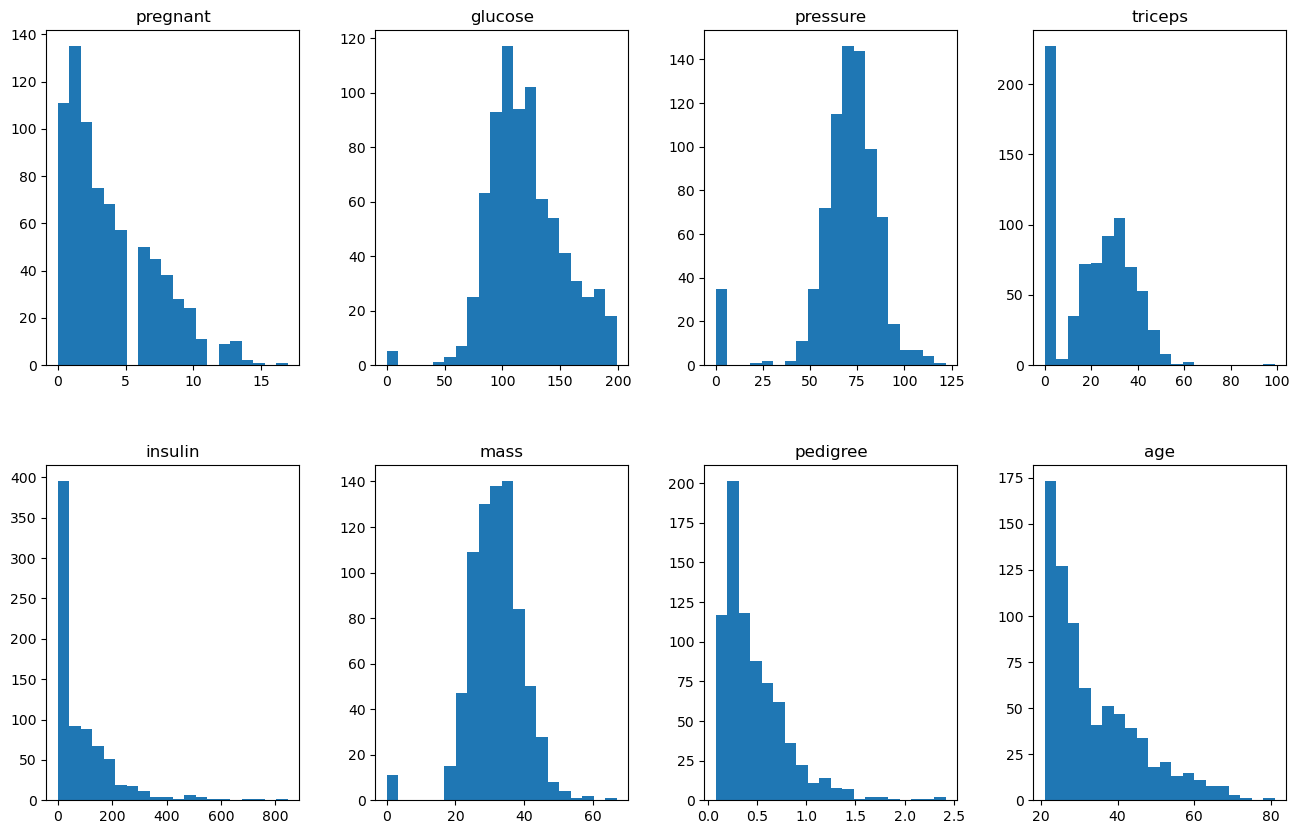

In [60]:
fig = diabetes.drop("diabetes", axis=1).hist(
    bins=20,
    figsize=(16, 10),
    layout=(2, 4),
    grid=False,
)

`glucose`, `pressure`, and  `mass` have some evidence of normality. `triceps` is potentially normal as well, if the zeros were removed. But the rest of the features are highly non-normal and should not be used in principle for this analysis.

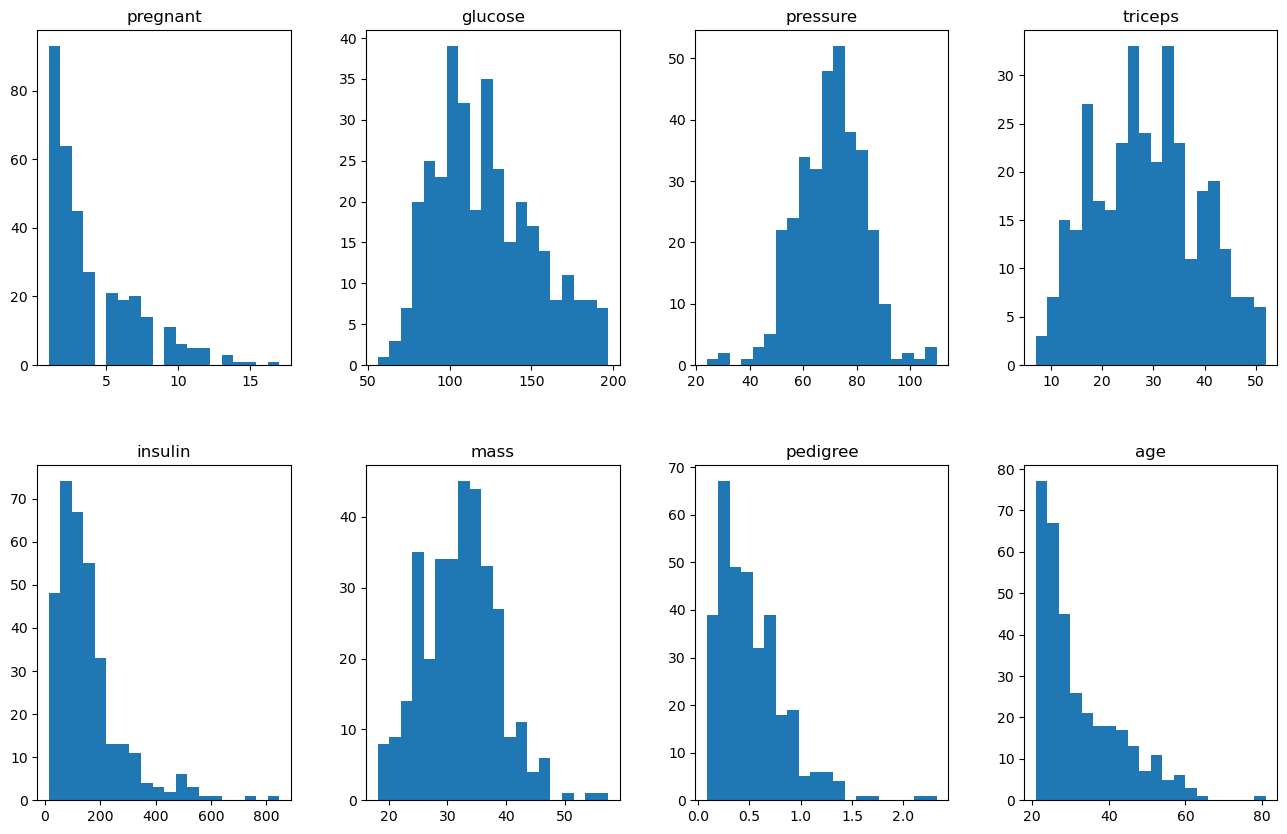

In [61]:
diabetes_nnonull = diabetes[
    (diabetes.drop("diabetes", axis=1) != 0).all(axis=1)
]

fig = diabetes_nnonull.drop("diabetes", axis=1).hist(
    bins=20,
    figsize=(16, 10),
    layout=(2, 4),
    grid=False,
)

Possibly normal columns after null removals:
- `glucose`
- `pressure`
- `triceps`
- `insulin` (unlikely)
- `mass`
- `pedigree` (unlikely)

Problem: This null removal massively shrank the training set.

In [63]:
print(f"Covariate dimensions prior to drop:  {diabetes.shape}")
print(f"Covariate dimensions after dropping: {diabetes_nnonull.shape}")

Covariate dimensions prior to drop:  (768, 9)
Covariate dimensions after dropping: (336, 9)


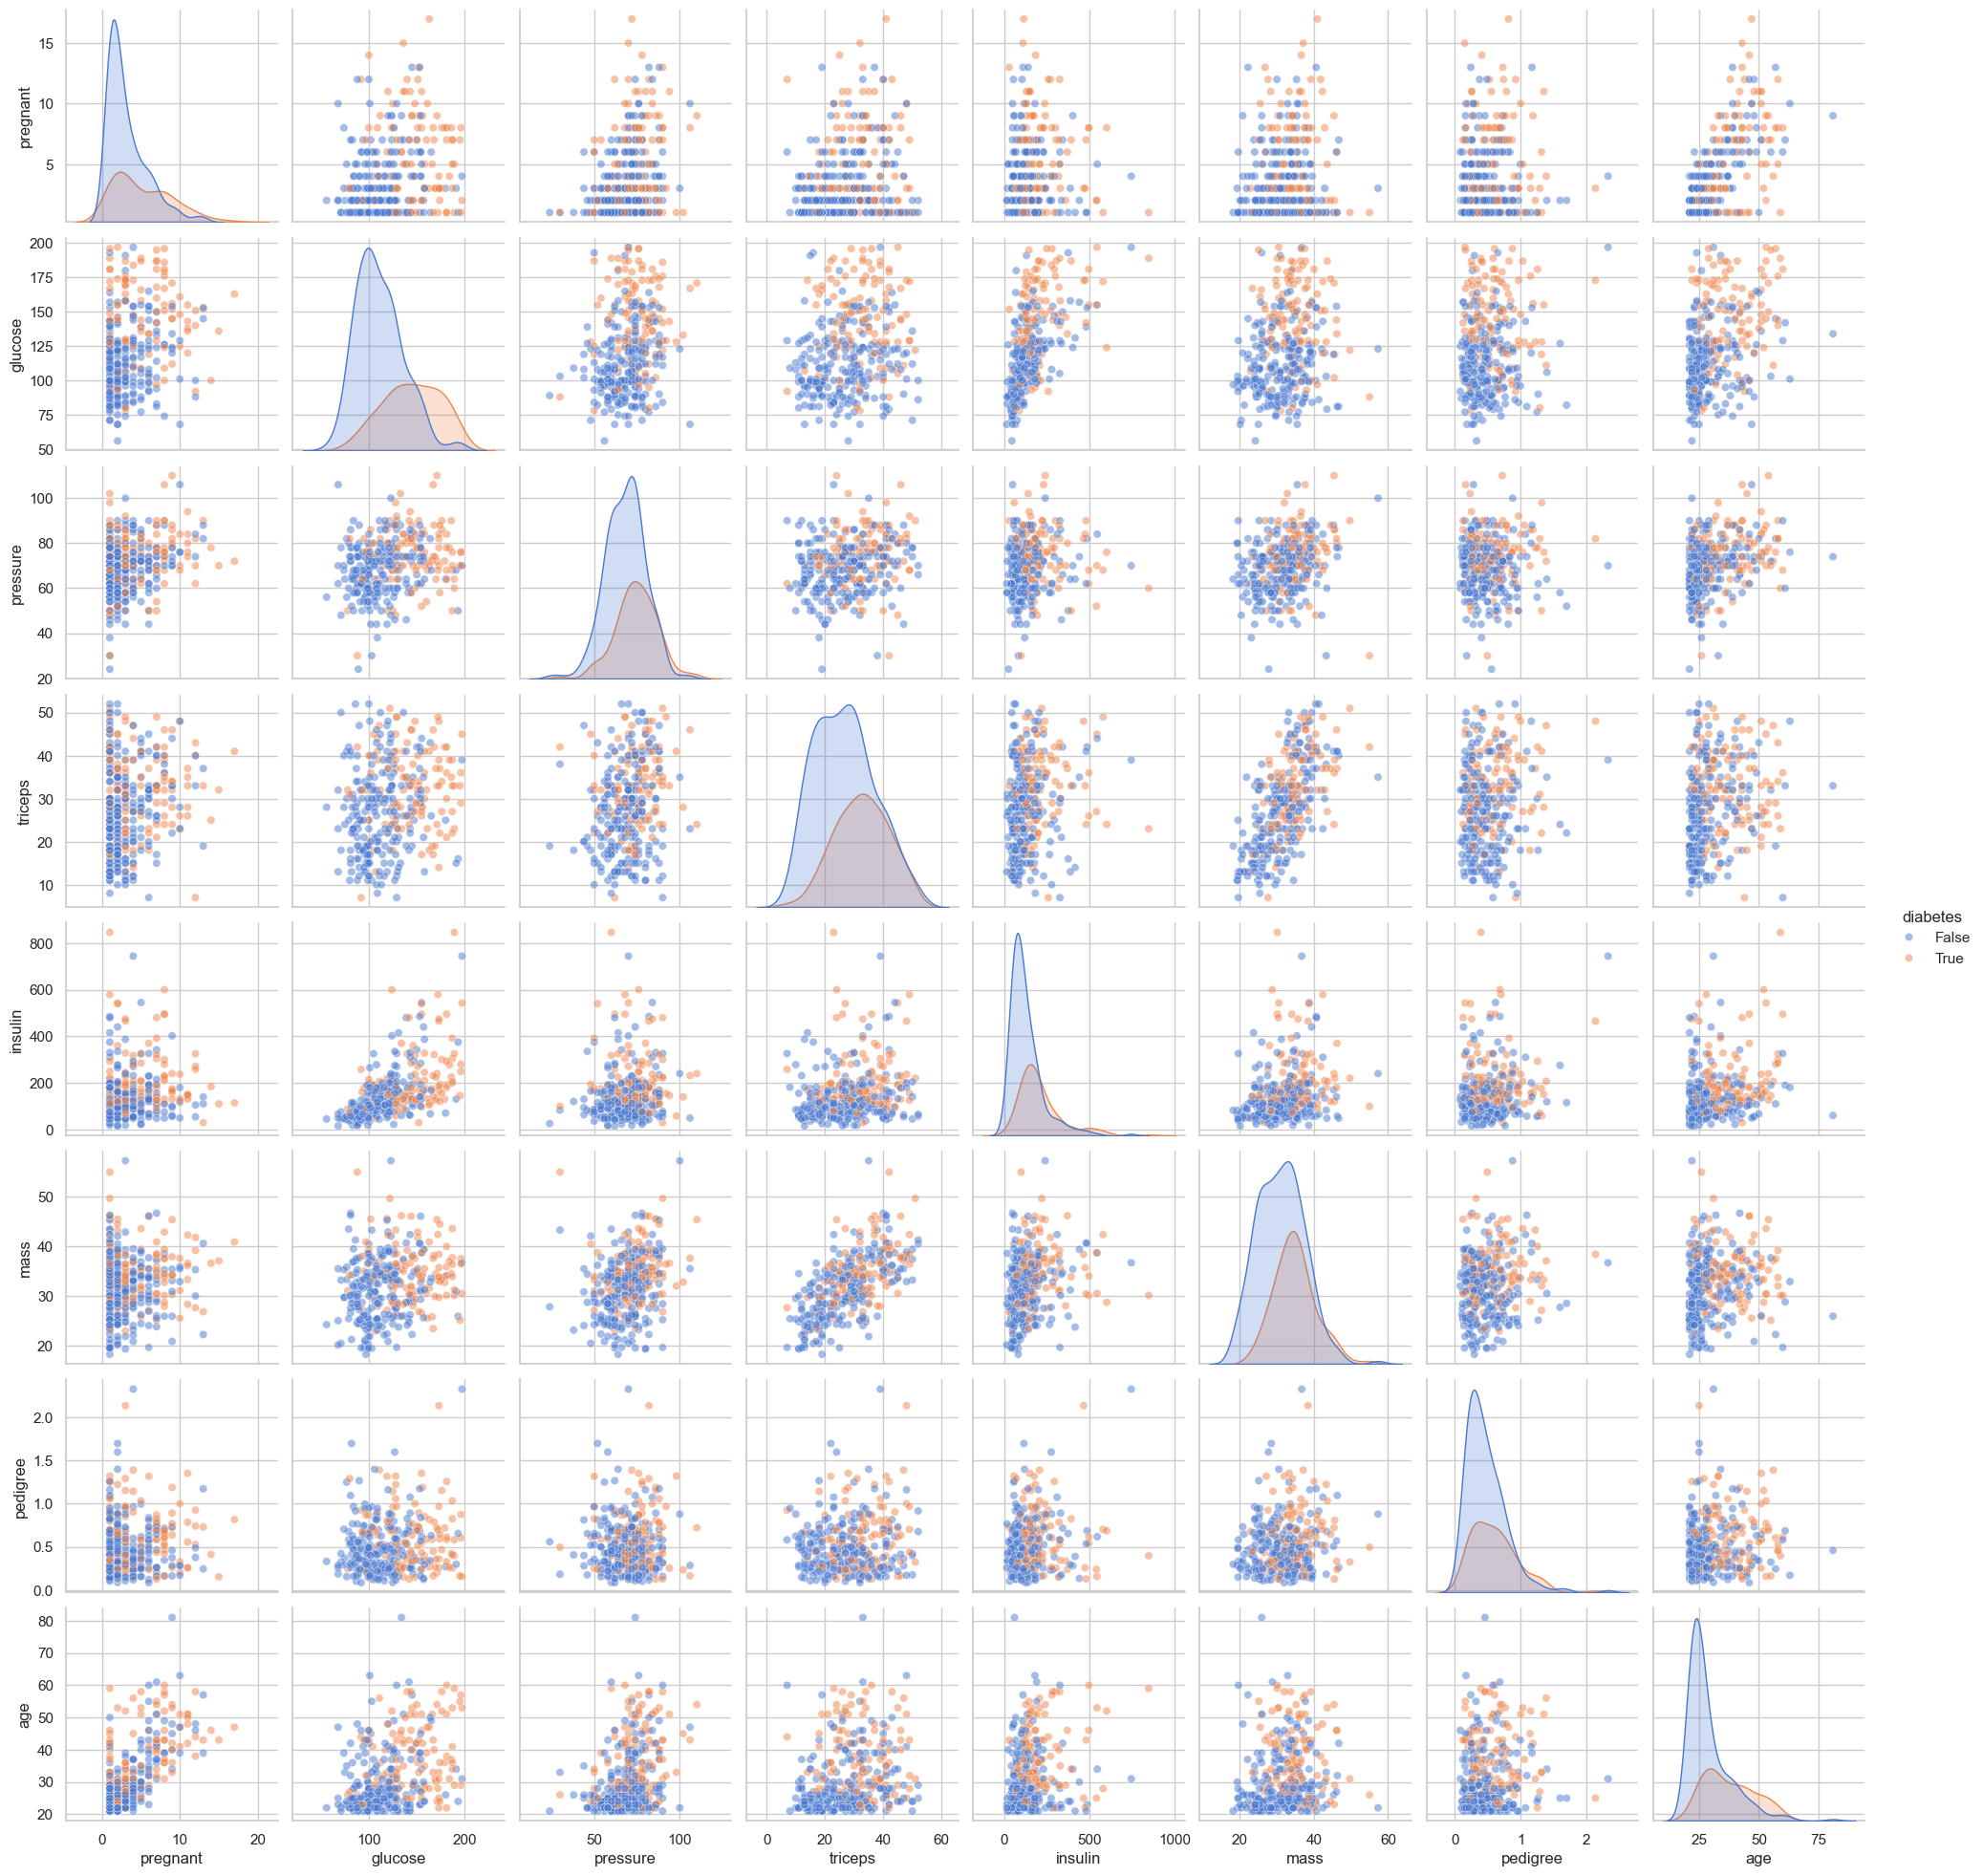

In [68]:
import seaborn as sns

# Disaggregated pairplot using non-null values
sns.set_theme(style="whitegrid", palette="muted")

sns.pairplot(
    diabetes_nnonull,
    hue="diabetes",
    diag_kind="kde",
    plot_kws={"alpha": 0.5},
    diag_kws={"fill": True},
)

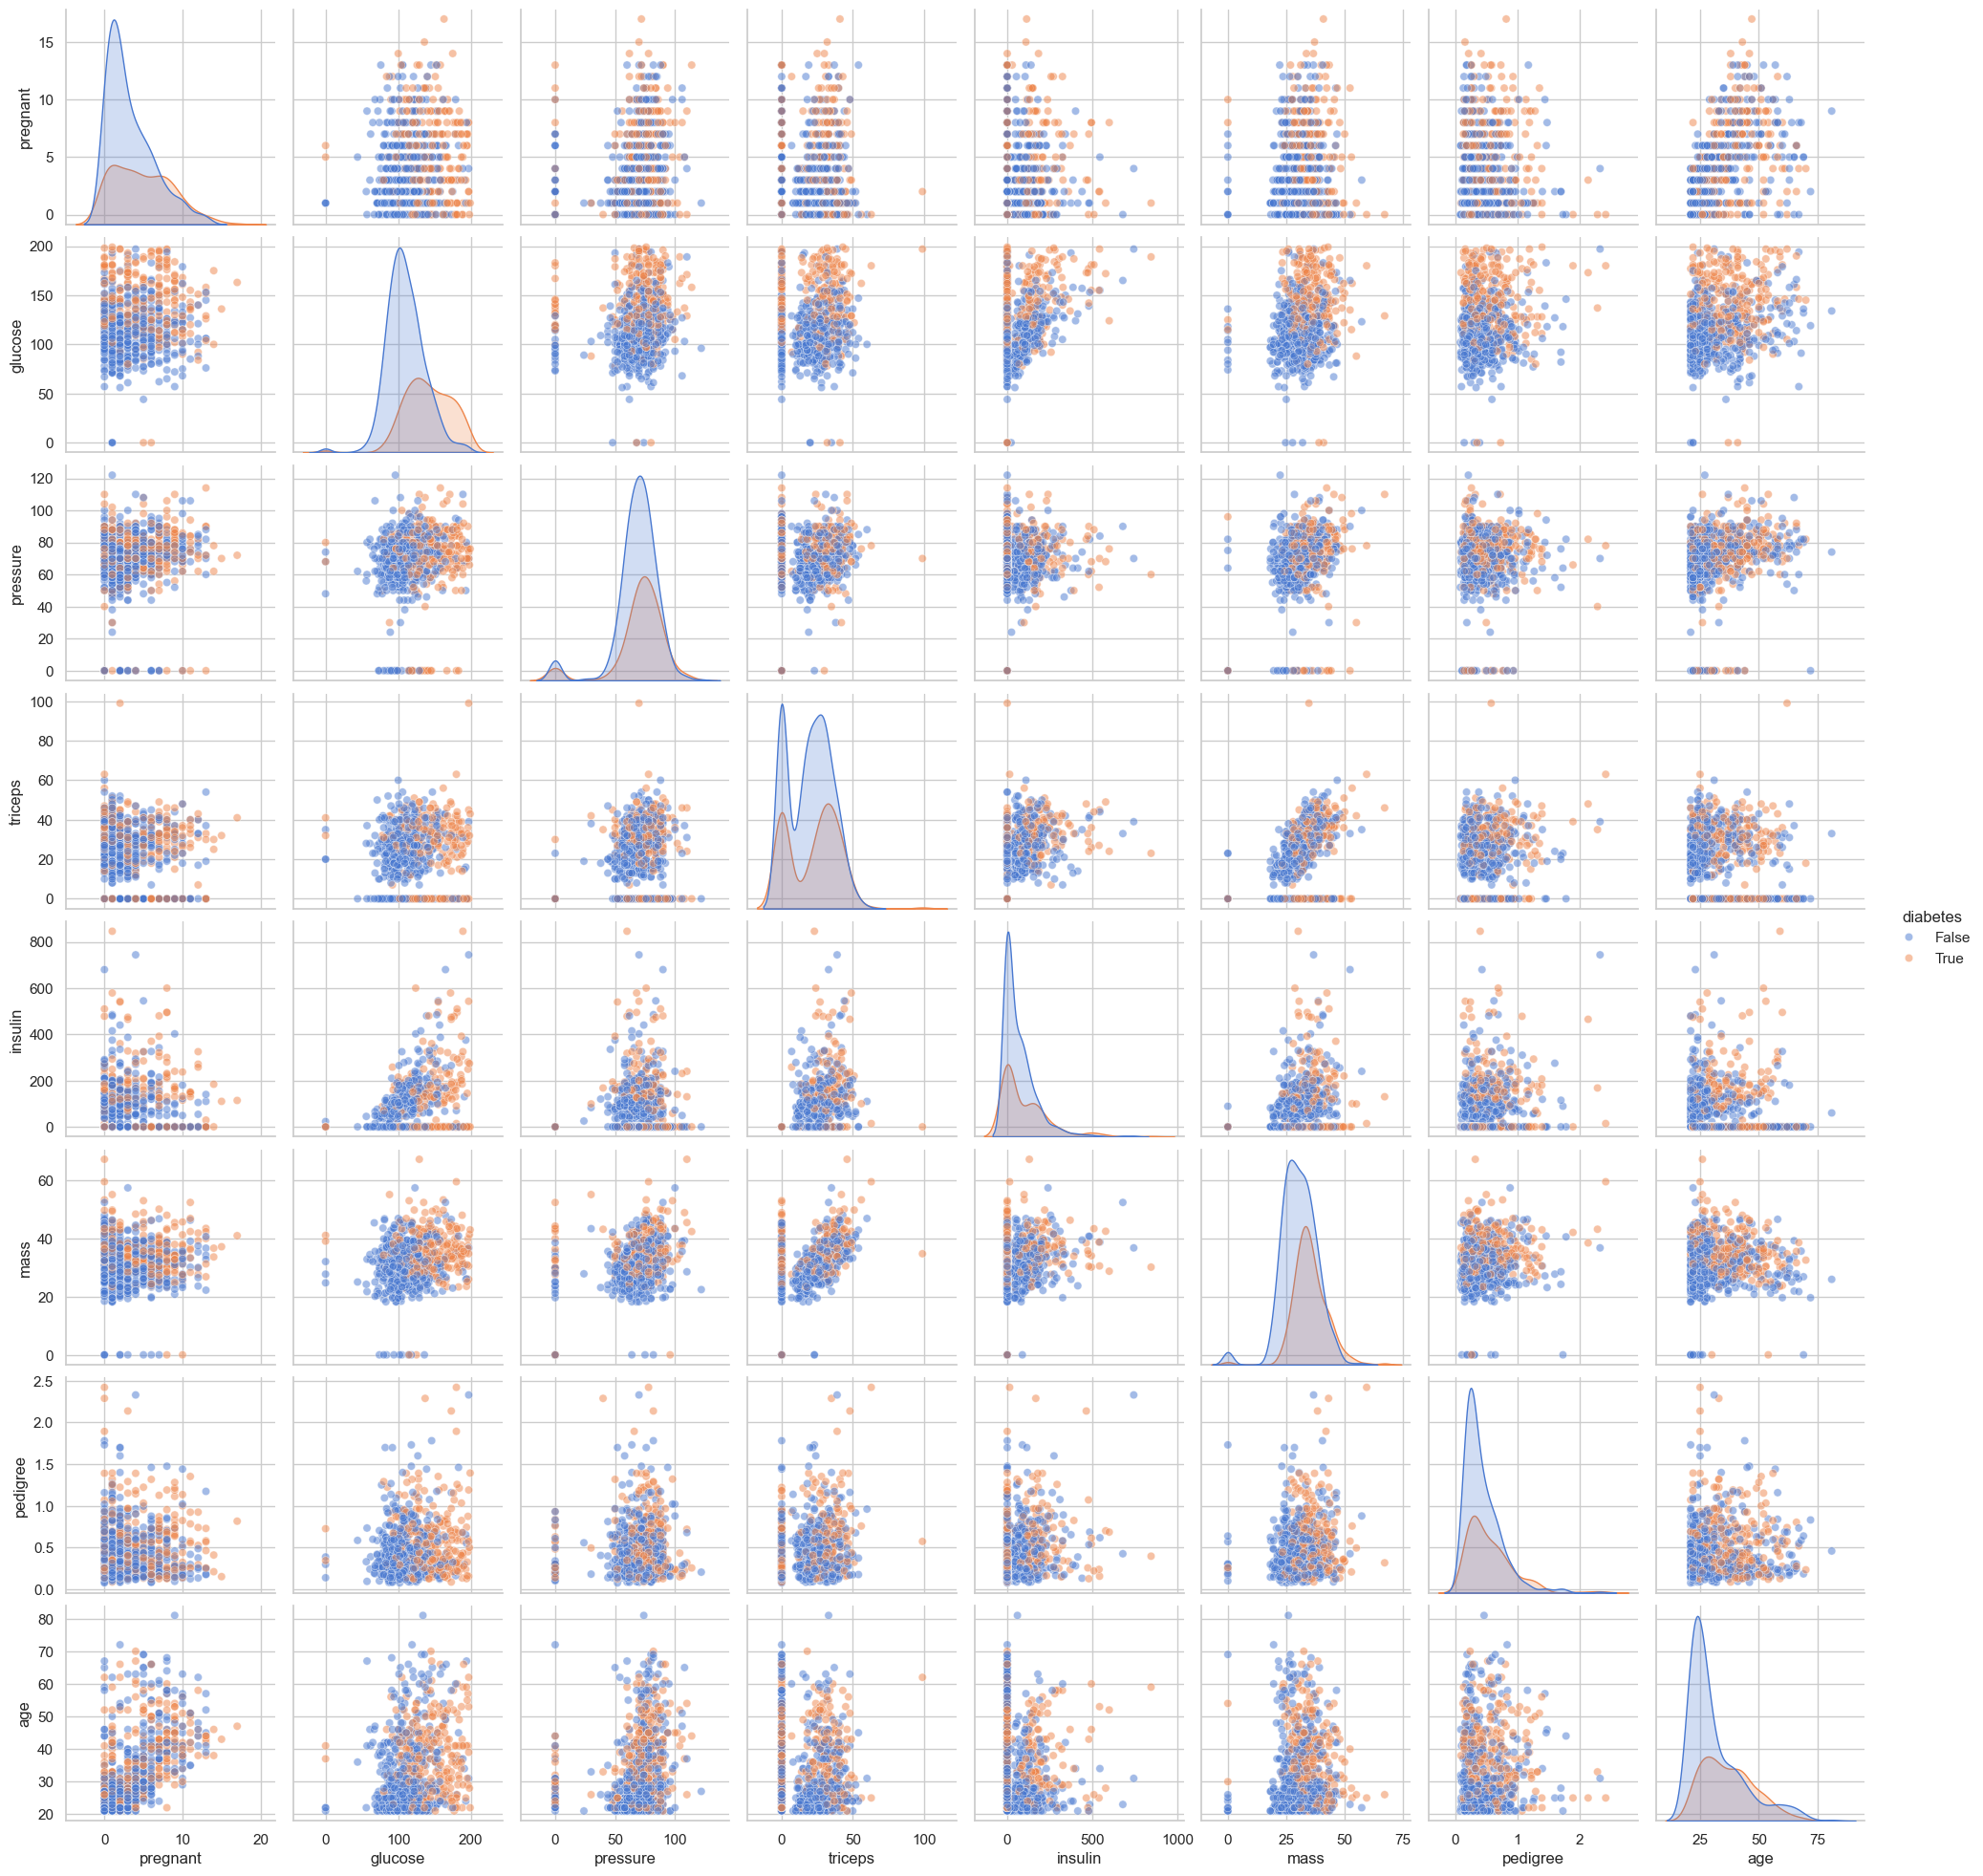

In [69]:
# Disaggregated pairplot using all of the data
sns.set_theme(style="whitegrid", palette="muted")

sns.pairplot(
    diabetes,
    hue="diabetes",
    diag_kind="kde",
    plot_kws={"alpha": 0.5},
    diag_kws={"fill": True},
)